# QAOA Braket

In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.timings import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from braket.aws import  AwsQuantumTask
import os

from quera_ahs_utils.plotting import (
    show_global_drive,
    show_register
)

from utils import cost_function
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import json

In [93]:
backends = {}
backends["quera_aquila"] = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
backends["braket_emulator"] = LocalSimulator("braket_ahs")

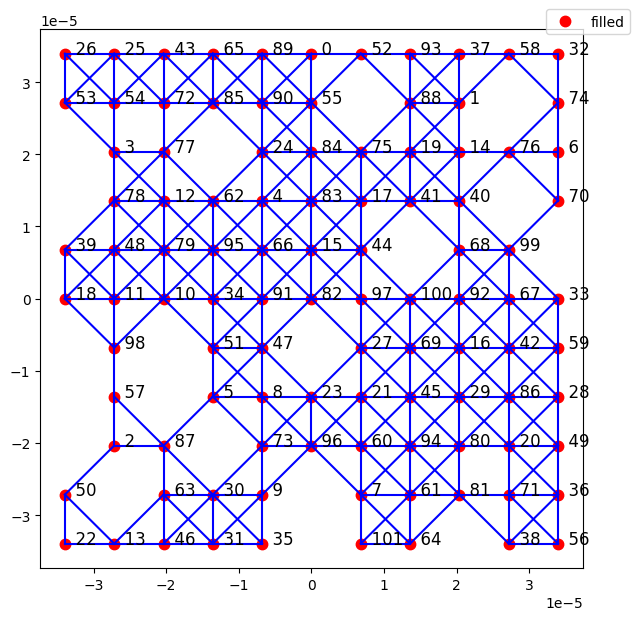

In [172]:
# Prepare Register

nq = 102
with open(f"./Data/problems/{nq}.json", "r") as file:
    problem = json.load(file)

G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])
register = AtomArrangement()
a = 6.79e-6
grid_side = problem["grid_side"]
pos = problem["pos"]
numx,numy = [grid_side,grid_side]
x_shift = a * (numx - 1) / 2
y_shift = a * (numy - 1) / 2
pos_dict = {}
for i, pos_i in enumerate(pos):
    register.add([round(pos_i[0] * a - x_shift,8), round(pos_i[1] * a - y_shift,8)])    
show_register(register, blockade_radius = np.sqrt(2)*a)


# show_global_drive(drive)

In [173]:
time_steps = {1e-6:0.45e-6, 2e-6:0.76e-6, 3e-6:1.1e-6, 4e-6:1.42e-6}

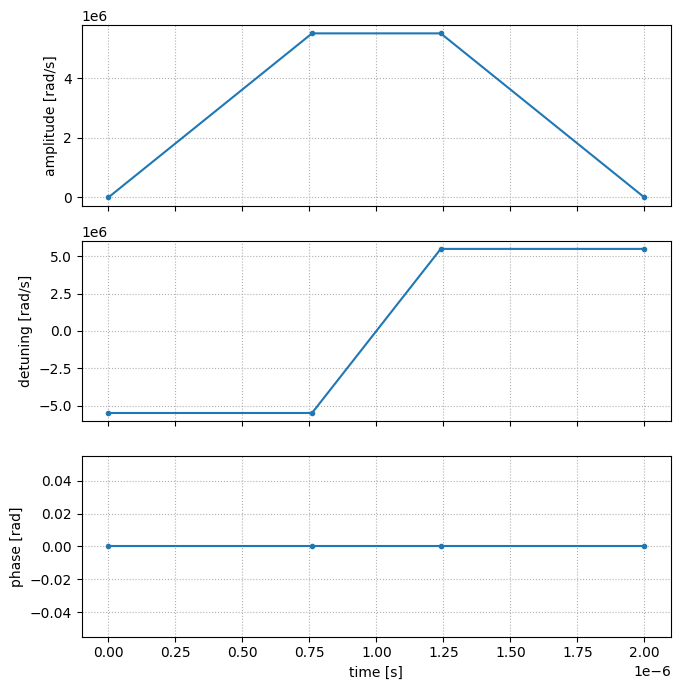

In [176]:
# Prepare Schedule (Independent of the problem size)

Omega_annealing = 5.5e6
Delta_g_0 = -5.5e6
Delta_g_annealing = -Delta_g_0

# total_time = [1e-6, 2e-6, 3e-6, 4e-6][3]
total_time = [2e-6, 4e-6][0]

t_ramp = {1e-6:0.45e-6, 2e-6:0.76e-6, 3e-6:1.1e-6, 4e-6:1.42e-6}[total_time]
t_sweep = total_time - 2 * t_ramp
t_delay = 0.0

t0 = t_delay
t1 = t0+t_ramp
t2 = t1 + t_sweep
t3 = t2 +t_ramp

omegas = [0,0, Omega_annealing,Omega_annealing,0.]
deltas = [Delta_g_0,Delta_g_0,Delta_g_0,Delta_g_annealing,Delta_g_annealing]
phis = len(omegas) * [0]

times = [0,t0,t1,t2,t3]

Omega = TimeSeries.from_lists(times, omegas)
Delta = TimeSeries.from_lists(times, deltas)
phi = TimeSeries.from_lists(times, phis)

drive = DrivingField(
    amplitude=Omega,
    phase=phi,
    detuning=Delta
)
show_global_drive(drive)

In [177]:
# Run experiment
shots = 500
case = 3
result = {}
result["time"] = times
result["Omegas"] = omegas
result["Deltas"] = deltas
# backend_name = "braket_emulator"
backend_name = "quera_aquila"
# Prepare Hamiltonian
ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=drive,
    register=register
)
job = backends[backend_name].run(ahs_program, shots=shots)
if backend_name == "braket_emulator":
    res = job.result()
    dict_counts = defaultdict(int)
    for k, count in res.get_counts().items():
        dict_counts["".join("1" if s == "r" else "0" for s in k)] += count
    result["samples"] = dict_counts
elif backend_name == "quera_aquila":
    arn = job.id
    result['arn'] = arn
result["shots"] = shots
os.makedirs(f"./Data/{backend_name}/QAA/{case}", exist_ok=True)
with open(f"./Data/{backend_name}/QAA/{case}/{nq}_t_{total_time}.json", "w") as file:
    json.dump(result, file)


# Postprocessing

In [178]:
# Postprocessing
nq = 34
case = 3
# backend_name = "braket_emulator"
total_time = [1e-6, 2e-6, 3e-6, 4e-6][3]
for nq in [11,13,17,21,25,30,34,41,56,70,84,85,100,102]:
    for total_time in [2e-6, 4e-6]:
        backend_name = "quera_aquila"
        with open(f"./Data/{backend_name}/QAA/{case}/{nq}_t_{total_time}.json", "r") as file:
            result = json.load(file)

        with open(f"./Data/problems/{nq}.json", "r") as file:
            problem = json.load(file)
        G = nx.Graph()
        G.add_nodes_from(range(nq))
        G.add_edges_from(problem["edges"])
        defects = 0
        if backend_name == "quera_aquila":
            arn = result['arn']
            res = AwsQuantumTask(arn = arn).result()
            dict_counts = defaultdict(int)
            dict_counts_1 = defaultdict(int)
            
            for k, count in res.get_counts().items():
                if not "e" in k:
                    dict_counts["".join("1" if s == "r" else "0" for s in k)] += count
                else:
                    defects += 1
            result["samples"] = dict_counts
        cost_evals = defaultdict(int)
        for k, v in result["samples"].items():
            cost = cost_function(k, G)
            cost_evals[cost] += v
        result["cost"] = cost_evals 
        result["defects"] = defects
        result["min_cost"] = cost_function(problem["sol"], G)
        print(f"Number of samples with defects: {defects}")
        with open(f"./Data/{backend_name}/QAA/{case}/{nq}_t_{total_time}.json", "w") as file:
            json.dump(result, file)

Number of samples with defects: 30
Number of samples with defects: 29
Number of samples with defects: 35
Number of samples with defects: 39
Number of samples with defects: 56
Number of samples with defects: 44
Number of samples with defects: 58
Number of samples with defects: 79
Number of samples with defects: 90
Number of samples with defects: 99
Number of samples with defects: 69
Number of samples with defects: 87
Number of samples with defects: 166
Number of samples with defects: 156
Number of samples with defects: 131
Number of samples with defects: 132
Number of samples with defects: 131
Number of samples with defects: 124
Number of samples with defects: 170
Number of samples with defects: 159
Number of samples with defects: 215
Number of samples with defects: 203
Number of samples with defects: 185
Number of samples with defects: 197
Number of samples with defects: 320
Number of samples with defects: 303
Number of samples with defects: 262
Number of samples with defects: 235


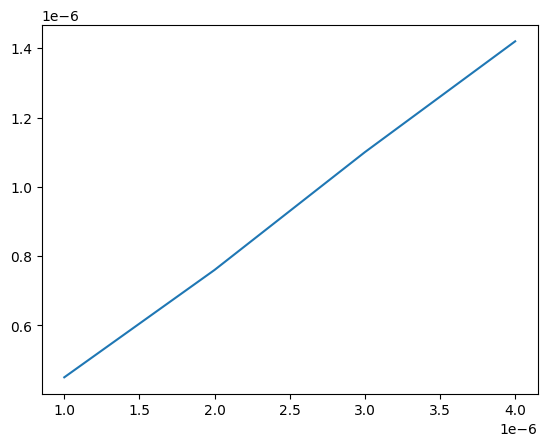

In [661]:
time_steps = {1e-6:0.45e-6, 2e-6:0.76e-6, 3e-6:1.1e-6, 4e-6:1.42e-6}

fig, ax = plt.subplots()
ax.plot(time_steps.keys(), time_steps.values())